In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rqdatac as rq
rq.init()

In [3]:
index_weight = pd.read_json("index_info.json")["weight"]
index_weight

PS    0.444935
V     0.118748
SF    0.156146
SA    0.063499
LC    0.137322
JM   -0.008427
MA    0.087255
AO   -0.007963
SP    0.066873
RU   -0.058390
Name: weight, dtype: float64

In [4]:
si_data = rq.futures.get_dominant_price("SI", frequency="1m").loc["SI"]
si_data

,trading_date,dominant_id,open,close,high,low,total_turnover,volume,open_interest
datetime,,,,,,,,,
2025-07-16 09:01:00,2025-07-16,SI2509,8780.0,8780.0,8805.0,8750.0,0,25389.0,396912.0
2025-07-16 09:02:00,2025-07-16,SI2509,8780.0,8790.0,8810.0,8780.0,0,11900.0,398632.0
2025-07-16 09:03:00,2025-07-16,SI2509,8795.0,8775.0,8795.0,8755.0,0,10213.0,398039.0
2025-07-16 09:04:00,2025-07-16,SI2509,8775.0,8765.0,8775.0,8755.0,0,8431.0,398165.0
2025-07-16 09:05:00,2025-07-16,SI2509,8765.0,8770.0,8770.0,8740.0,0,9360.0,398378.0
...,...,...,...,...,...,...,...,...,...
2025-10-15 14:56:00,2025-10-15,SI2511,8565.0,8565.0,8570.0,8560.0,0,432.0,145108.0
2025-10-15 14:57:00,2025-10-15,SI2511,8565.0,8565.0,8565.0,8555.0,0,1166.0,145037.0
2025-10-15 14:58:00,2025-10-15,SI2511,8565.0,8580.0,8580.0,8560.0,0,1211.0,144758.0


In [5]:
def preprocess(data: tuple):

    minute_price = data["close"]
    minute_price.loc[data["trading_date"].iloc[0] + pd.Timedelta(hours=9)] = data["open"].iloc[0]
    minute_price = minute_price.sort_index()
    trading_date = minute_price.index.strftime("%Y-%m-%d")
    mask = (minute_price.index >= pd.to_datetime(trading_date + " 09:00:00")) & \
           (minute_price.index <= pd.to_datetime(trading_date + " 15:00:00"))
    minute_price = minute_price[mask]

    return minute_price

In [6]:
def preprocess_vwap(data: tuple):

    minute_vwap = (data["close"] * data["volume"]).cumsum() / data["volume"].cumsum()
    minute_vwap.loc[data["trading_date"].iloc[0] + pd.Timedelta(hours=9)] = data["open"].iloc[0]
    minute_vwap = minute_vwap.sort_index()
    trading_date = minute_vwap.index.strftime("%Y-%m-%d")
    mask = (minute_vwap.index >= pd.to_datetime(trading_date + " 09:00:00")) & \
           (minute_vwap.index <= pd.to_datetime(trading_date + " 15:00:00"))
    minute_vwap = minute_vwap[mask]
    minute_vwap = minute_vwap / minute_vwap.iloc[0]

    return minute_vwap

In [7]:
si_minute = si_data.groupby("trading_date").apply(preprocess)
si_minute.name = "SI"
si_val = si_minute.groupby(level=0).apply(lambda x: (((x.diff() / x.shift()).fillna(0) + 1).cumprod())).droplevel(0)
si_val

trading_date  datetime           
2025-07-16    2025-07-16 09:00:00    1.000000
              2025-07-16 09:01:00    1.000000
              2025-07-16 09:02:00    1.001139
              2025-07-16 09:03:00    0.999431
              2025-07-16 09:04:00    0.998292
                                       ...   
2025-10-15    2025-10-15 14:56:00    1.008240
              2025-10-15 14:57:00    1.008240
              2025-10-15 14:58:00    1.010006
              2025-10-15 14:59:00    1.008829
              2025-10-15 15:00:00    1.008829
Name: SI, Length: 13560, dtype: float64

In [8]:
si_vwap = si_data.groupby("trading_date").apply(preprocess_vwap)
si_vwap

trading_date  datetime           
2025-07-16    2025-07-16 09:00:00    1.000000
              2025-07-16 09:01:00    1.000000
              2025-07-16 09:02:00    1.000363
              2025-07-16 09:03:00    1.000163
              2025-07-16 09:04:00    0.999881
                                       ...   
2025-10-15    2025-10-15 14:56:00    1.012120
              2025-10-15 14:57:00    1.012098
              2025-10-15 14:58:00    1.012085
              2025-10-15 14:59:00    1.012070
              2025-10-15 15:00:00    1.011790
Length: 13560, dtype: float64

In [9]:
all_minute = pd.DataFrame()
for underlying in index_weight.index:
    data = rq.futures.get_dominant_price(underlying, frequency="1m").loc[underlying]
    data.to_csv("data/%s.csv" % underlying.lower())
    minute = data.groupby("trading_date").apply(preprocess)
    minute.name = underlying
    all_minute = pd.concat([all_minute, minute], axis=1)

all_minute

PS       V      SF      SA       LC  \
2025-07-16 2025-07-16 09:00:00  42290.0  5124.0  5636.0  1310.0  67680.0   
           2025-07-16 09:01:00  42210.0  5108.0  5610.0  1308.0  67380.0   
           2025-07-16 09:02:00  42490.0  5110.0  5612.0  1309.0  67340.0   
           2025-07-16 09:03:00  42290.0  5109.0  5616.0  1309.0  67420.0   
           2025-07-16 09:04:00  42245.0  5108.0  5618.0  1310.0  67300.0   
...                                 ...     ...     ...     ...      ...   
2025-10-15 2025-10-15 14:57:00  50535.0  4675.0  5352.0  1230.0  72980.0   
           2025-10-15 14:58:00  50740.0  4677.0  5352.0  1231.0  73000.0   
           2025-10-15 14:59:00  50890.0  4676.0  5348.0  1231.0  73000.0   
           2025-10-15 15:00:00  50865.0  4677.0  5352.0  1232.0  72940.0   
2025-10-16 2025-10-16 09:00:00      NaN  4673.0     NaN  1235.0      NaN   

                                    JM      MA      AO      SP       RU  
2025-07-16 2025-07-16 09:00:00  1027.5  2482.0  3229.0  5582.0  15300.0  
           2025-07-16 09:01:00  1021.5  2472.0  3202.0  5562.0  15325.0  
           2025-07-16 09:02:00  1023.0  2475.0  3209.0  5564.0  15330.0  
           2025-07-16 09:03:00  1021.5  2475.0  3207.0  5564.0  15330.0  
           2025-07-16 09:04:00  1022.5  2475.0  3212.0  5564.0  15340.0  
...                                ...     ...     ...     ...      ...  
2025-10-15 2025-10-15 14:57:00  1149.0  2296.0  2795.0  5170.0  14865.0  
           2025-10-15 14:58:00  1151.0  2299.0  2798.0  5170.0  14875.0  
           2025-10-15 14:59:00  1151.0  2298.0  2797.0  5170.0  14880.0  
           2025-10-15 15:00:00  1151.0  2298.0  2797.0  5170.0  14895.0  
2025-10-16 2025-10-16 09:00:00  1155.0  2299.0  2799.0  5172.0  14895.0  

[13561 rows x 10 columns]

In [10]:
index_val = all_minute.groupby(level=0).apply(lambda x: (((x.diff() / x.shift()).apply(lambda y: y.dot(index_weight), axis=1)).fillna(0) + 1).cumprod()).droplevel(0)
index_val = index_val.rename_axis(["trading_date", "datetime"])
index_val

trading_date  datetime           
2025-07-16    2025-07-16 09:00:00    1.000000
              2025-07-16 09:01:00    0.996791
              2025-07-16 09:02:00    0.999883
              2025-07-16 09:03:00    0.998057
              2025-07-16 09:04:00    0.997363
                                       ...   
2025-10-15    2025-10-15 14:57:00    1.005917
              2025-10-15 14:58:00    1.007925
              2025-10-15 14:59:00    1.009053
              2025-10-15 15:00:00    1.008854
2025-10-16    2025-10-16 09:00:00    1.000000
Length: 13561, dtype: float64

In [11]:
val_diff = index_val.reindex(si_val.index) - si_val
counts, bin_edges = np.histogram(val_diff, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

def normal_func(x, mu, sigma, amplitude):
    return amplitude * norm.pdf(x, mu, sigma)

# 使用曲线拟合
params, params_covariance = optimize.curve_fit(
    normal_func, bin_centers, counts, p0=[val_diff.mean(), val_diff.std(), counts.max()]
)

print(f"拟合参数: μ={params[0]:.6f}, σ={params[1]:.6f}, 幅度={params[2]:.6f}")

拟合参数: μ=0.000362, σ=0.010464, 幅度=11.358433


In [12]:
confidence_levels = [0.10, 0.20, 0.30]  # 10%, 20%, 30%水平

print("标准正态分布的单边分位数:")
for level in confidence_levels:
    z_score = norm.ppf(1 - level)  # ppf是分位数函数
    print(f"{int(level*100)}%水平: μ + {z_score:.4f}σ")

标准正态分布的单边分位数:
10%水平: μ + 1.2816σ
20%水平: μ + 0.8416σ
30%水平: μ + 0.5244σ


In [13]:
si_val.name = "si"
index_val.name = "index"
val_diff.name = "spread"

data = pd.concat([val_diff, si_val, index_val], axis=1)
data

spread        si     index
trading_date datetime                                         
2025-07-16   2025-07-16 09:00:00  0.000000  1.000000  1.000000
             2025-07-16 09:01:00 -0.003209  1.000000  0.996791
             2025-07-16 09:02:00 -0.001256  1.001139  0.999883
             2025-07-16 09:03:00 -0.001374  0.999431  0.998057
             2025-07-16 09:04:00 -0.000929  0.998292  0.997363
...                                    ...       ...       ...
2025-10-15   2025-10-15 14:57:00 -0.002323  1.008240  1.005917
             2025-10-15 14:58:00 -0.002081  1.010006  1.007925
             2025-10-15 14:59:00  0.000224  1.008829  1.009053
             2025-10-15 15:00:00  0.000026  1.008829  1.008854
2025-10-16   2025-10-16 09:00:00       NaN       NaN  1.000000

[13561 rows x 3 columns]

In [14]:
def add_lag(data: pd.DataFrame):
    for lag in range(1, 3):
        data["si_lag_%d" % lag] = data["si"].shift(lag)
        data["index_lag_%d" % lag] = data["index"].shift(lag)
    return data

lag_data = data.groupby(level=0).apply(add_lag).droplevel(0).dropna(how="any")
lag_data

spread        si     index  si_lag_1  \
trading_date datetime                                                      
2025-07-16   2025-07-16 09:02:00 -0.001256  1.001139  0.999883  1.000000   
             2025-07-16 09:03:00 -0.001374  0.999431  0.998057  1.001139   
             2025-07-16 09:04:00 -0.000929  0.998292  0.997363  0.999431   
             2025-07-16 09:05:00 -0.001832  0.998861  0.997029  0.998292   
             2025-07-16 09:06:00 -0.001400  0.997722  0.996322  0.998861   
...                                    ...       ...       ...       ...   
2025-10-15   2025-10-15 14:56:00 -0.002561  1.008240  1.005680  1.007652   
             2025-10-15 14:57:00 -0.002323  1.008240  1.005917  1.008240   
             2025-10-15 14:58:00 -0.002081  1.010006  1.007925  1.008240   
             2025-10-15 14:59:00  0.000224  1.008829  1.009053  1.010006   
             2025-10-15 15:00:00  0.000026  1.008829  1.008854  1.008829   

                                  index_lag_1  si_lag_2  index_lag_2  
trading_date datetime                                                 
2025-07-16   2025-07-16 09:02:00     0.996791  1.000000     1.000000  
             2025-07-16 09:03:00     0.999883  1.000000     0.996791  
             2025-07-16 09:04:00     0.998057  1.001139     0.999883  
             2025-07-16 09:05:00     0.997363  0.999431     0.998057  
             2025-07-16 09:06:00     0.997029  0.998292     0.997363  
...                                       ...       ...          ...  
2025-10-15   2025-10-15 14:56:00     1.006667  1.008240     1.007910  
             2025-10-15 14:57:00     1.005680  1.007652     1.006667  
             2025-10-15 14:58:00     1.005917  1.008240     1.005680  
             2025-10-15 14:59:00     1.007925  1.008240     1.005917  
             2025-10-15 15:00:00     1.009053  1.010006     1.007925  

[13440 rows x 7 columns]

In [15]:
X = lag_data.drop(["spread", "si", "index"], axis=1)
X = sm.add_constant(X)
y = lag_data["si"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     si   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.263e+05
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:53:31   Log-Likelihood:                 67757.
No. Observations:               13440   AIC:                        -1.355e+05
Df Residuals:                   13435   BIC:                        -1.355e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0018      0.001      1.581      

In [16]:
(val_diff.groupby(level=0).apply(lambda x: adfuller(x)[1]) < 0.05).sum()

11

In [17]:
((si_val - si_vwap).fillna(method="bfill").groupby(level=0).apply(lambda x: adfuller(x)[1]) < 0.05).sum()

8

In [18]:
def daily_series(panel: pd.DataFrame, diff: bool=False):
    all_daily = pd.DataFrame()
    for data in panel.groupby(level=0):
        daily = data[1].droplevel(0)
        daily.name = daily.index[0].strftime("%Y%m%d")
        daily.index = daily.index.map(lambda x: x.strftime("%H%M%S"))
        all_daily = pd.concat([all_daily, daily], axis=1)
    if diff:
        all_daily = all_daily.diff().dropna()
    return all_daily.reset_index(drop=True)

In [19]:
def long_data_export(all_daily: pd.DataFrame):
    all_daily_long = all_daily.stack().reset_index()
    all_daily_long.columns = ["time", "date", "value"]
    all_daily_long["date"] = pd.to_datetime(all_daily_long["date"])
    all_daily_long = all_daily_long.sort_values(by=["date", "time"]).reset_index(drop=True)
    all_daily_long.to_csv("si_daily_minute.csv")

In [20]:
long_data_export(daily_series(val_diff))

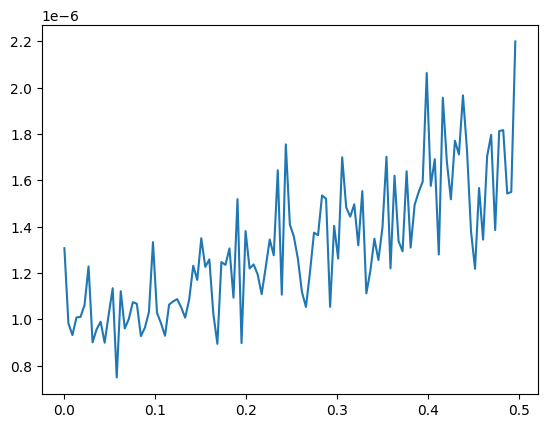

In [21]:
panel = daily_series(val_diff)

def spectral_analysis(series: pd.Series):
    fft_result = np.fft.fft(series.diff().dropna())
    n = len(panel.index)
    freq = np.fft.fftfreq(n)
    psd = np.abs(fft_result) ** 2 / n
    return pd.Series(psd[: n//2], index=freq[: n//2])

average_spectral_power = panel.apply(spectral_analysis).mean(axis=1)
plt.plot(average_spectral_power)
plt.show()

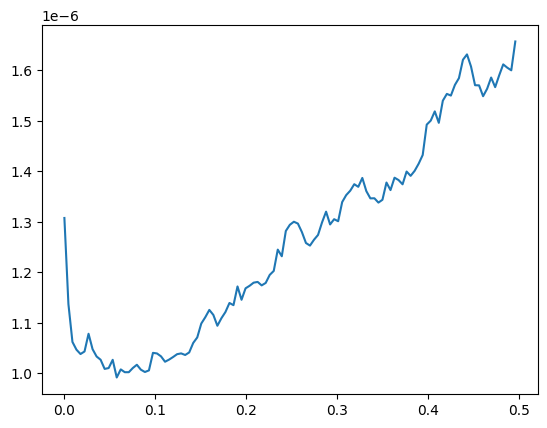

In [22]:
plt.plot(average_spectral_power.ewm(span=20, ignore_na=True).mean())
plt.show()

In [23]:
model = ARIMA(val_diff, order=(1, 0, 1))
print(model.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                 spread   No. Observations:                13560
Model:                 ARIMA(1, 0, 1)   Log Likelihood               67956.910
Date:                Thu, 16 Oct 2025   AIC                        -135905.819
Time:                        08:53:36   BIC                        -135875.760
Sample:                             0   HQIC                       -135895.796
                              - 13560                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.143      0.886      -0.004       0.003
ar.L1          0.9923      0.001    746.634      0.000       0.990       0.995
ma.L1         -0.0650      0.003    -24.794      0.0

In [24]:
val_diff.groupby(level=0).std().mean()

0.005144902164866597

In [25]:
(si_val - si_vwap).groupby(level=0).std().mean()

0.00536591677721307

In [26]:
intra_chg = si_data.groupby("trading_date").apply(lambda x: x["close"].iloc[-1] - x["open"].iloc[3]).iloc[1:]
daily_chg = si_data.groupby("trading_date")["close"].last().diff().dropna()
intra_prop = intra_chg / daily_chg
intra_prop = intra_prop[~np.isinf(intra_prop)].iloc[:-1]
intra_prop.describe()

count    57.000000
mean      0.817867
std       1.405267
min      -4.750000
25%       0.285714
50%       0.909091
75%       1.368421
max       3.857143
dtype: float64

In [27]:
y = intra_chg
X = daily_chg
X = sm.add_constant(X)

print(sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 10}).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     361.7
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           2.34e-26
Time:                        08:53:37   Log-Likelihood:                -355.80
No. Observations:                  59   AIC:                             715.6
Df Residuals:                      57   BIC:                             719.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.2336      8.497      2.734      0.0

<Axes: xlabel='trading_date'>

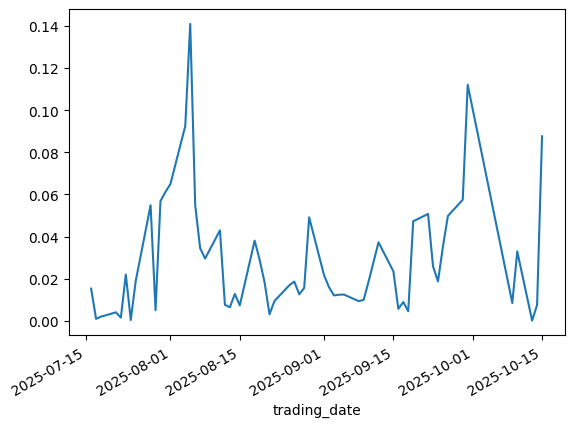

In [28]:
vol2oi = si_data.groupby("trading_date").apply(lambda x: abs(x["open_interest"].iloc[-1] - x["open_interest"].iloc[0]) / x["volume"].sum())
vol2oi.plot()

In [29]:
windows = 3
rol_std = si_data.groupby("trading_date")["close"].apply(lambda x: x.rolling(windows).std().dropna())
rol_vol = si_data.groupby("trading_date")["volume"].rolling(windows).mean().dropna()

y = rol_std
X = rol_vol
X = sm.add_constant(X)

print(sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 1}).summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     674.2
Date:                Thu, 16 Oct 2025   Prob (F-statistic):          4.69e-145
Time:                        08:53:37   Log-Likelihood:                -43216.
No. Observations:               13380   AIC:                         8.644e+04
Df Residuals:                   13378   BIC:                         8.645e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7358      0.124     38.145      0.0

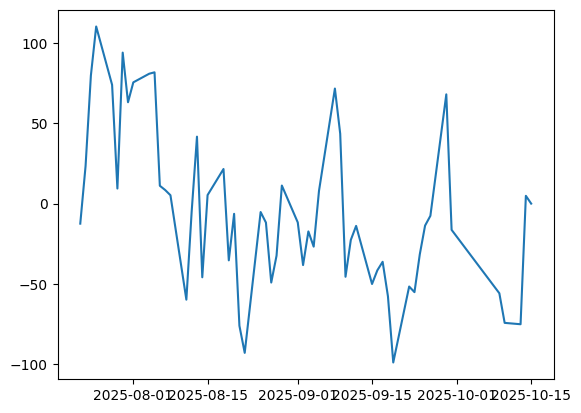

In [30]:
spread = si_minute.groupby(level=0).transform("first") * val_diff
spread = spread.groupby(level=0).apply(lambda x: ((x + x.shift()) / 2).dropna()).droplevel([0, 1])
vw_spread = spread * si_data["volume"]
vw_spread = vw_spread.groupby(vw_spread.index.date).apply(lambda x: x.cumsum()) / si_data["volume"].groupby(si_data.index.date).apply(lambda x: x.cumsum())

def discnt_sum(series: pd.Series):
    n = len(series)
    discnt = pd.Series([np.exp(0.5*i) for i in range(n)], index=series.index)
    discnt = discnt / discnt.sum()
    return (series * discnt).sum()

cum_diff = vw_spread.groupby(level=0).last().rolling(5).apply(discnt_sum).dropna()
plt.plot(cum_diff)
plt.show()

In [ ]:
def regression(si_series: pd.Series):
    y = si_series
    X = (index_val.diff() / index_val.shift()).reindex(si_series.index)
    X = sm.add_constant(X)
    return sm.OLS(y, X).fit().params["index"]

beta = (si_val.diff() / si_val.shift()).groupby(level=0).rolling(5).apply(regression).droplevel(0).dropna()
beta

trading_date  datetime           
2025-07-16    2025-07-16 09:05:00    0.297696
              2025-07-16 09:06:00    0.560198
              2025-07-16 09:07:00    0.872164
              2025-07-16 09:08:00    0.227733
              2025-07-16 09:09:00    0.958452
                                       ...   
2025-10-15    2025-10-15 14:56:00   -0.278965
              2025-10-15 14:57:00   -0.110300
              2025-10-15 14:58:00    0.553357
              2025-10-15 14:59:00    0.293537
              2025-10-15 15:00:00    0.207776
Name: si, Length: 13319, dtype: float64

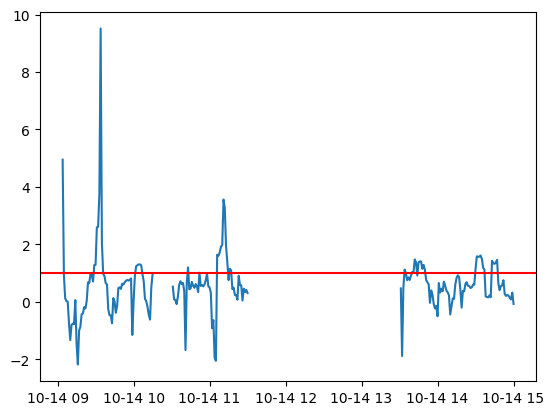

In [66]:
test_beta = beta.xs(pd.to_datetime("20251014"), level=0).asfreq("1min")

plt.plot(test_beta)
plt.axhline(1, color="red")
plt.show()

In [62]:
volume = si_data["volume"]
rol_vol = volume.groupby(volume.index.date).rolling(5).mean().dropna()

y = beta.reindex(rol_vol.index)
X = rol_vol
X = sm.add_constant(X)
print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                     si   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     270.2
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           3.99e-60
Time:                        09:17:02   Log-Likelihood:                -18532.
No. Observations:               13260   AIC:                         3.707e+04
Df Residuals:                   13258   BIC:                         3.708e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9112      0.012     76.159      0.0

In [ ]:
all_y = si_val.diff() / si_val.shift()
all_X = index_val.diff() / index_val.shift()

pos_y = all_y[all_y >= 0]
neg_y = all_y[all_y < 0]
pos_X = all_X[pos_y.index]
neg_X = all_X[neg_y.index]

pos_beta = sm.OLS(pos_y, sm.add_constant(pos_X)).fit().params.iloc[0]
neg_beta = sm.OLS(neg_y, sm.add_constant(neg_X)).fit().params.iloc[0]

0.0006004814416378934